[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://github.com/CodingPro777/AAI-530-GROUP-1/edit/main/final_project_code.ipynb
)


# USD AAI-530 Group 1 final project - Machine Learning with IoT(FitBit Fitness)

*Group 1 members: Ali Abdul-Hameed, Jack Kim, Jinyuan He*


In [226]:
# load packages
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns


# 1. Data cleaning & EDA

## 1.1 Loading dataset

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# upload dataset zip file to google drive if not exist
google_drive_path = '/content/drive/MyDrive/USD/2026 Spring/AAI-530-GROUP-1'

zip_file_path = google_drive_path + '/archive.zip'

if not os.path.isfile(zip_file_path):
  from google.colab import files
  uploaded = files.upload()
  !mv archive.zip '/content/drive/MyDrive/USD/2026 Spring/AAI-530-GROUP-1'


!unzip '/content/drive/MyDrive/USD/2026 Spring/AAI-530-GROUP-1/archive.zip'

Archive:  /content/drive/MyDrive/USD/2026 Spring/AAI-530-GROUP-1/archive.zip
replace mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/dailyActivity_merged.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/heartrate_seconds_merged.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [61]:
# combine two months dataset into one

raw_daily_activity_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/dailyActivity_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv')]
)

raw_weight_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/weightLogInfo_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv')]
)

raw_hr_sec_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/heartrate_seconds_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/heartrate_seconds_merged.csv')]
)

raw_calories_min_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteCaloriesNarrow_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteCaloriesNarrow_merged.csv')]
)

raw_intensities_min_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteIntensitiesNarrow_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteIntensitiesNarrow_merged.csv')]
)

raw_mets_min_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteMETsNarrow_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteMETsNarrow_merged.csv')]
)

raw_sleep_min_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteSleep_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteSleep_merged.csv')]
)


raw_step_min_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteStepsNarrow_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteStepsNarrow_merged.csv')]
)

## 1.2 Dataset for calories prediction

In [62]:
calories_df = raw_calories_min_df.merge(
    raw_intensities_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

calories_df = calories_df.merge(
    raw_mets_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

calories_df = calories_df.merge(
    raw_step_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

calories_df['ActivityMinute'] = pd.to_datetime(
    calories_df['ActivityMinute'],
    format='%m/%d/%Y %I:%M:%S %p'
)

raw_weight_df['Date'] = pd.to_datetime(
    raw_weight_df['Date'],
    format='%m/%d/%Y %I:%M:%S %p'
)

# sort these two datasets
calories_df = calories_df.sort_values(
    ['ActivityMinute', 'Id']
).reset_index(drop=True)

raw_weight_df = raw_weight_df.sort_values(
    ['Date', 'Id']
).reset_index(drop=True)

calories_merged_df = pd.merge_asof(
    calories_df,
    raw_weight_df[['Id', 'Date', 'WeightPounds', 'BMI']],
    left_on='ActivityMinute',
    right_on='Date',
    by='Id',                # match same user
    direction='backward'    # use latest weight BEFORE activity time
)

In [63]:
calories_merged_df.isna().sum()

,0
Id,0
ActivityMinute,0
Calories,0
Intensity,0
METs,0
Steps,0
Date,2296122
WeightPounds,2296122
BMI,2296122


In [64]:
# Forward fill weight-related columns by user
cols_to_fill = ['WeightPounds', 'BMI']

calories_merged_df[cols_to_fill] = (
    calories_merged_df
        .groupby('Id')[cols_to_fill]
        .transform(lambda x: x.ffill().bfill())
)

In [65]:
calories_merged_df.isna().sum()

,0
Id,0
ActivityMinute,0
Calories,0
Intensity,0
METs,0
Steps,0
Date,2296122
WeightPounds,1848540
BMI,1848540


In [66]:
# remove the data which doesn't have WeightPounds, BMI
calories_merged_df.dropna(subset=['WeightPounds', 'BMI'], inplace=True)
calories_merged_df.drop(columns=['Date'], inplace=True)
calories_merged_df.isna().sum()

,0
Id,0
ActivityMinute,0
Calories,0
Intensity,0
METs,0
Steps,0
WeightPounds,0
BMI,0


In [67]:
number_cols = [
    'Calories',
    'Intensity',
    'METs',
    'Steps',
    'WeightPounds',
    'BMI'
]

calories_merged_df[number_cols] = calories_merged_df[number_cols].apply(pd.to_numeric)

In [68]:
pd.options.display.float_format = '{:.0f}'.format
calories_merged_df.describe()

,Id,ActivityMinute,Calories,Intensity,METs,Steps,WeightPounds,BMI
count,1069080,1069080,1069080,1069080,1069080,1069080,1069080,1069080
mean,4687112516,2016-04-10 21:02:08.603658752,2,0,15,6,176,28
min,1503960366,2016-03-12 00:00:00,0,0,0,0,116,21
25%,2873212765,2016-03-27 11:12:00,1,0,10,0,137,24
50%,4558609924,2016-04-12 00:45:00,1,0,10,0,167,26
75%,5577150313,2016-04-24 18:27:00,1,0,12,0,204,28
max,8877689391,2016-05-12 15:59:00,19,3,157,207,294,48
std,2274543825,NaN,1,1,13,19,48,7


### 1.2.1 Check minute-level time continuity in the dataset

In [69]:
# Sort by value
calories_merged_df = calories_merged_df.sort_values(['Id', 'ActivityMinute'], ascending=True)

# Remove duplicated data
calories_merged_df = calories_merged_df.drop_duplicates(subset=['Id', 'ActivityMinute'])

# Check minute-level time continuity in the dataset
calories_merged_df.groupby('Id')['ActivityMinute'].diff().value_counts().head()

,count
ActivityMinute,
0 days 00:01:00,1017763
0 days 04:01:00,2
3 days 01:01:00,1
0 days 02:01:00,1
0 days 14:01:00,1


#### PS: The minute-level activity data is largely continuous, with over 99% of consecutive records occurring at 1-minute intervals. A small number of duplicate timestamps and occasional multi-hour gaps were observed, likely due to device synchronization or user inactivity.

In [70]:
# We mark time gaps in the data so that the records can be separated into sessions or removed when training time-series models.
calories_merged_df['minute_gap'] = (
    calories_merged_df.groupby('Id')['ActivityMinute']
      .diff()
      .dt.total_seconds()
      .div(60)
)

calories_merged_df['has_gap'] = (calories_merged_df['minute_gap'] > 1).astype(int)

### 1.2.2 EDA

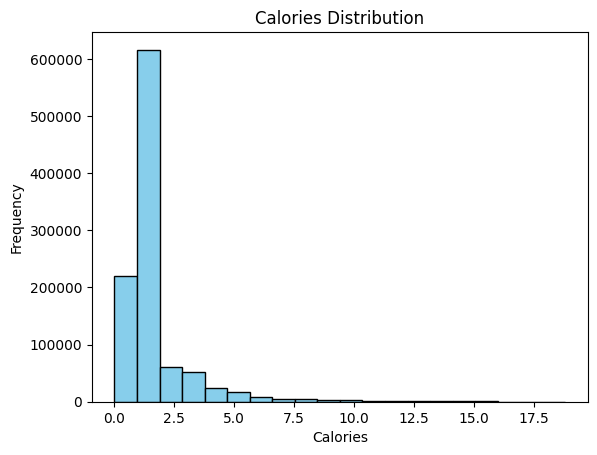

In [71]:

plt.hist(calories_merged_df['Calories'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.title('Calories Distribution')
plt.show()

array([[<Axes: title={'center': 'Steps'}>,
        <Axes: title={'center': 'METs'}>],
       [<Axes: title={'center': 'Intensity'}>, <Axes: >]], dtype=object)

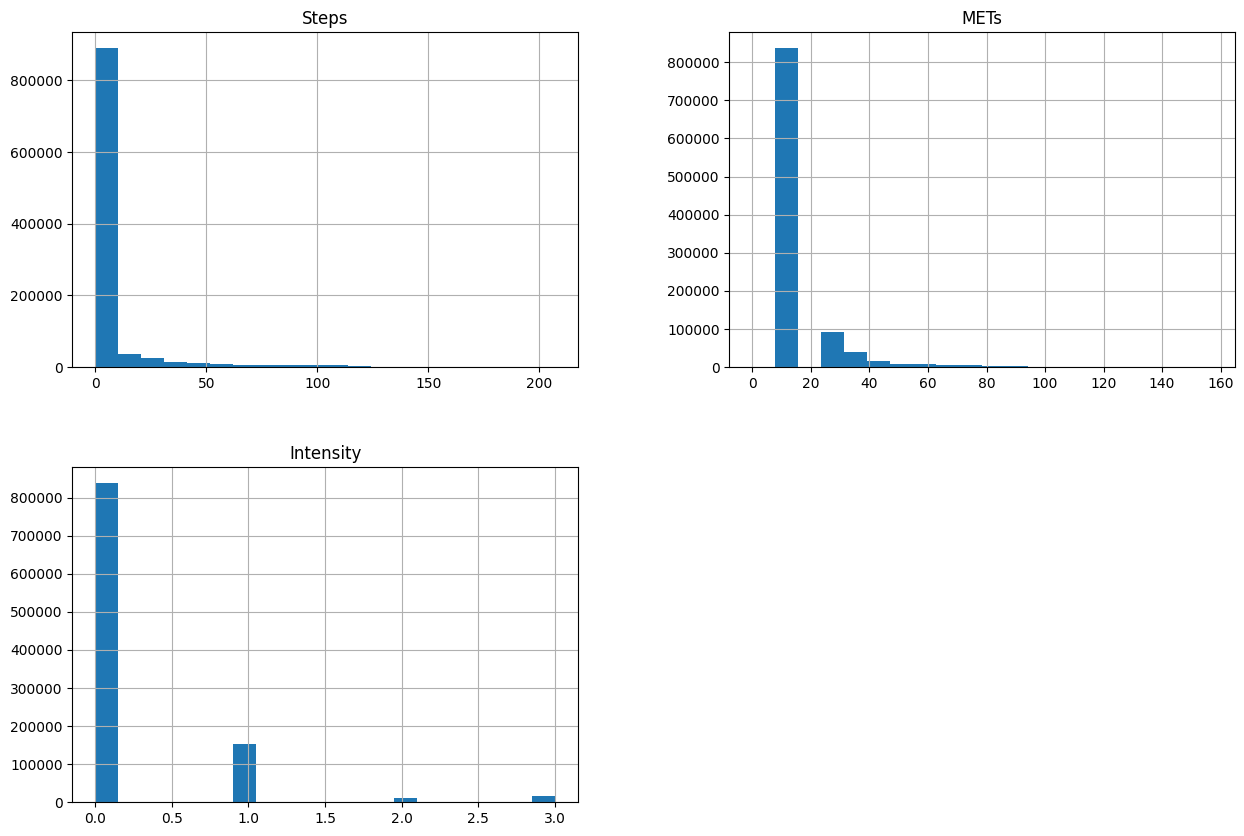

In [72]:
calories_merged_df[['Steps', 'METs', 'Intensity']].hist(bins=20, figsize=(15,10))

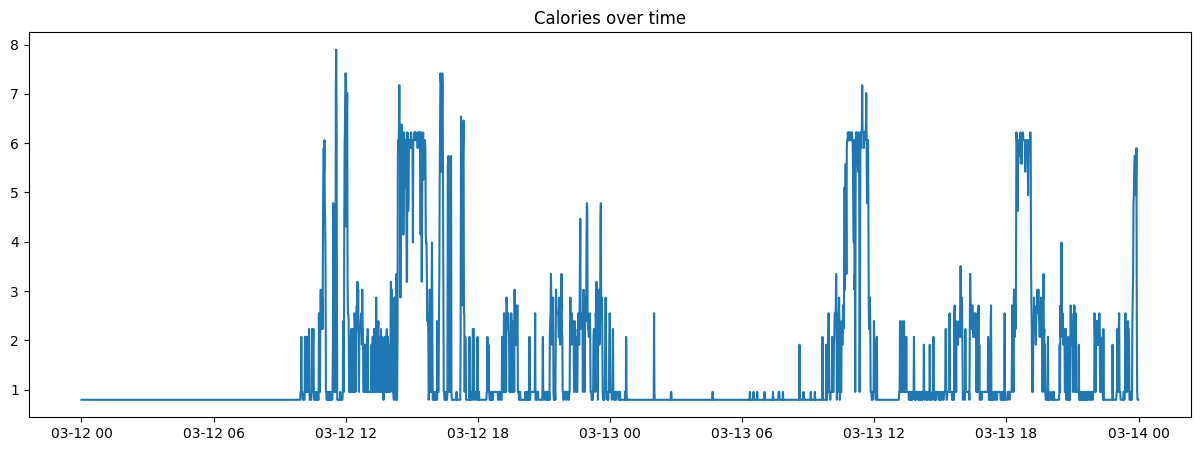

In [73]:
uid = calories_merged_df['Id'].iloc[0]

sample = (
    calories_merged_df[calories_merged_df['Id'] == uid]
        .head(2 * 24 * 60)
)
plt.figure(figsize=(15, 5))
plt.plot(sample['ActivityMinute'], sample['Calories'], label='Calories')
plt.title('Calories over time')
plt.show()

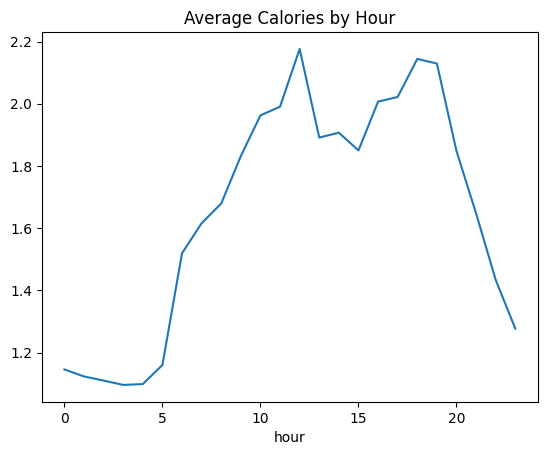

In [74]:
calories_merged_df['hour'] = calories_merged_df['ActivityMinute'].dt.hour

calories_merged_df.groupby('hour')['Calories'].mean().plot(kind='line')
plt.title('Average Calories by Hour')
plt.show()

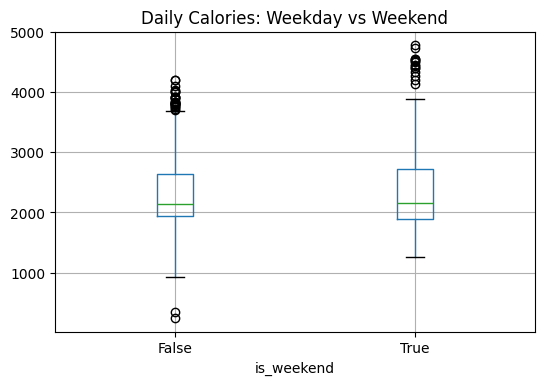

In [75]:
df = calories_merged_df.copy()

df["dayofweek"] = df["ActivityMinute"].dt.dayofweek
# Monday=0, Sunday=6
df["is_weekend"] = df["dayofweek"].isin([5, 6])

daily = (
    df.groupby(["Id", "is_weekend", df["ActivityMinute"].dt.date])["Calories"]
      .sum()
      .reset_index()
)

daily.boxplot(column="Calories", by="is_weekend", figsize=(6,4))
plt.title("Daily Calories: Weekday vs Weekend")
plt.suptitle("")
plt.show()

#### Interpretation

**1. Calories Distribution**
From the calories distribution, we observe that most calories burned per minute fall within the range of approximately 0 to 1.5, forming a right-skewed distribution. This indicates that while most minutes involve low energy expenditure, users occasionally reach much higher calorie burn levels, likely during periods of exercise. Similarly, Steps, METs, and Intensity exhibit comparable right-skewed patterns, reflecting sporadic bursts of higher activity.

**2. Hourly Activity Pattern**
The hourly average plot shows that calorie expenditure is lowest during nighttime hours and higher during daytime, corresponding to typical human activity and rest cycles. This pattern is consistent with expected daily routines and supports the validity of the data.

**3. Weekday vs. Weekend Comparison**
The boxplot comparison indicates that daily calories burned on weekends are slightly higher than on weekdays. This suggests that people may engage in more outdoor or leisure activities on weekends, leading to increased overall energy expenditure compared to weekdays.



### 1.2.3 Features Correlation

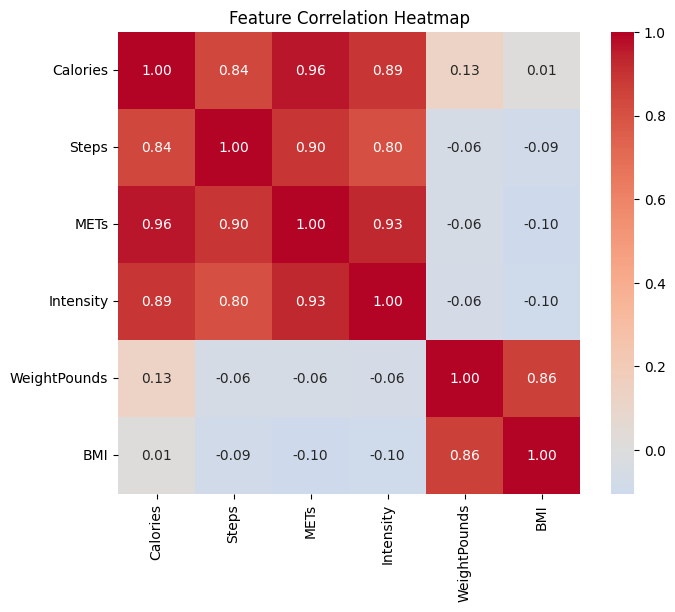

In [76]:
corr = calories_merged_df[
    ['Calories','Steps','METs','Intensity','WeightPounds','BMI']
].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,        # show correlation values
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True
)
plt.title("Feature Correlation Heatmap")
plt.show()

## 1.3 Dataset for sleep status prediction



*   Merge sleep status with heart rate(min, max, avg)/Intensity/METs
*   Split into contiguous segments (per user)
*   Filter long segments




In [163]:
# ensure datetime
raw_hr_sec_df['Time'] = pd.to_datetime(raw_hr_sec_df['Time'])

# drill up to minute
raw_hr_sec_df['ActivityMinute'] = raw_hr_sec_df['Time'].dt.floor('min')

# aggregate
hr_min_df = (
    raw_hr_sec_df.groupby(['Id', 'ActivityMinute'])['Value']
      .agg(
          min_hr='min',
          max_hr='max',
          avg_hr='mean'
      )
      .reset_index()
)

In [206]:
# Merge sleep status with heart rate(min, max, avg)/Intensity/METs
raw_intensities_min_df['ActivityMinute'] = pd.to_datetime(
    raw_intensities_min_df['ActivityMinute']
)

raw_mets_min_df['ActivityMinute'] = pd.to_datetime(
    raw_mets_min_df['ActivityMinute']
)

raw_step_min_df['ActivityMinute'] = pd.to_datetime(
    raw_step_min_df['ActivityMinute']
)

raw_sleep_min_df['date'] = pd.to_datetime(
    raw_sleep_min_df['date'],
    format='%m/%d/%Y %I:%M:%S %p'
)

sleep_status_df = hr_min_df.merge(
    raw_intensities_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

sleep_status_df = sleep_status_df.merge(
    raw_mets_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

sleep_status_df = sleep_status_df.merge(
    raw_step_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

sleep_status_df = sleep_status_df.merge(
    raw_sleep_min_df,
    left_on=['Id', 'ActivityMinute'],
    right_on=['Id', 'date'],
    how='left'
)

In [207]:
sleep_status_df.dropna(inplace=True)
sleep_status_df.drop(columns=['date', 'logId'], inplace=True)
sleep_status_df.isna().sum()

,0
Id,0
ActivityMinute,0
min_hr,0
max_hr,0
avg_hr,0
Intensity,0
METs,0
Steps,0
value,0


In [208]:
# Sort by value
sleep_status_df = sleep_status_df.sort_values(['Id', 'ActivityMinute'], ascending=True)

# Remove duplicated data
sleep_status_df = sleep_status_df.drop_duplicates(subset=['Id', 'ActivityMinute'])
sleep_status_df.dropna(subset=['value'], inplace=True)

# Check minute-level time continuity in the dataset
sleep_status_df.groupby('Id')['ActivityMinute'].diff().value_counts()

,count
ActivityMinute,
0 days 00:01:00,67769
0 days 00:02:00,26
0 days 00:03:00,19
0 days 00:05:00,12
0 days 00:04:00,10
...,...
0 days 17:25:00,1
0 days 16:41:00,1
0 days 17:16:00,1


In [209]:
sleep_status_df['time_diff'] = (
    sleep_status_df.groupby('Id')['ActivityMinute']
      .diff()
      .dt.total_seconds()
)

In [210]:
# Split into contiguous segments (per user)
sleep_status_df['time_diff'] = (
    sleep_status_df.groupby('Id')['ActivityMinute']
      .diff()
      .dt.total_seconds()
)

EXPECTED_INTERVAL = 60   # second
THRESHOLD = 60 * 60 * 2  # 2 hours

sleep_status_df['new_segment'] = (
    (sleep_status_df['time_diff'] > THRESHOLD) |
    sleep_status_df['time_diff'].isna()
)

sleep_status_df['segment_id'] = (
    sleep_status_df.groupby('Id')['new_segment']
      .cumsum()
)

sleep_status_df['segment_uid'] = (
    sleep_status_df['Id'].astype(str) + '_' +
    sleep_status_df['segment_id'].astype(str)
)

# Filter long segments
segment_stats = (
    sleep_status_df.groupby(['Id', 'segment_uid'])
      .agg(
          start_time=('ActivityMinute', 'min'),
          end_time=('ActivityMinute', 'max'),
          n_points=('ActivityMinute', 'count')
      )
      .reset_index()
)

segment_stats['duration_sec'] = (
    segment_stats['end_time'] - segment_stats['start_time']
).dt.total_seconds()

valid_segments = segment_stats[
    segment_stats['duration_sec'] >= THRESHOLD
]

sleep_status_merge_df = sleep_status_df.merge(
    valid_segments[['segment_uid']],
    on='segment_uid',
    how='inner'
)

In [211]:
sleep_status_merge_df.groupby('segment_uid')['ActivityMinute'].diff().value_counts().head()

,count
ActivityMinute,
0 days 00:01:00,66654
0 days 00:02:00,23
0 days 00:03:00,18
0 days 00:05:00,10
0 days 00:04:00,10


### 1.3.1 EDA

In [212]:
print(f"""
Number of users: {sleep_status_merge_df['Id'].nunique()}
Number of segments: {sleep_status_merge_df['segment_uid'].nunique()}
Number of points: {sleep_status_merge_df['ActivityMinute'].count()}

Longest segment: {sleep_status_merge_df['segment_uid'].value_counts().max() / 60} hours
Shortest segment: {sleep_status_merge_df['segment_uid'].value_counts().min() / 60} hours
Average segment: {sleep_status_merge_df['segment_uid'].value_counts().mean() / 60} hours
""")


Number of users: 10
Number of segments: 153
Number of points: 66936
      
Longest segment: 12.066666666666666 hours
Shortest segment: 2.15 hours
Average segment: 7.291503267973856 hours



In [213]:
sleep_status_merge_df.describe()

,Id,ActivityMinute,min_hr,max_hr,avg_hr,Intensity,METs,Steps,value,time_diff,segment_id
count,66936,66936,66936,66936,66936,66936,66936,66936,66936,66927,66936
mean,5717265331,2016-04-20 02:27:36.124955392,61,64,62,0,10,0,1,375,11
min,2347167796,2016-03-29 00:00:00,37,41,39,0,10,0,1,60,1
25%,4388161847,2016-04-09 01:48:00,55,58,56,0,10,0,1,60,5
50%,5577150313,2016-04-20 01:13:00,60,63,62,0,10,0,1,60,11
75%,6962181067,2016-05-01 02:37:00,65,69,67,0,10,0,1,60,16
max,8792009665,2016-05-12 08:00:00,122,128,126,1,70,49,3,1455900,30
std,1801445211,NaN,9,10,9,0,2,1,0,10046,7


<Axes: xlabel='length', ylabel='Count'>

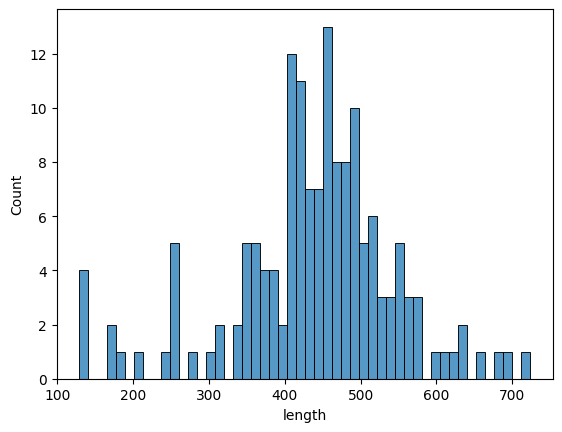

In [214]:
segment_stats = (
    sleep_status_merge_df.groupby(['Id','segment_uid'])
      .size()
      .reset_index(name='length')
)

sns.histplot(segment_stats['length'], bins=50)

In [215]:
sleep_status_merge_df['value'].value_counts().sort_index()


,count
value,
1,62980
2,3321
3,635


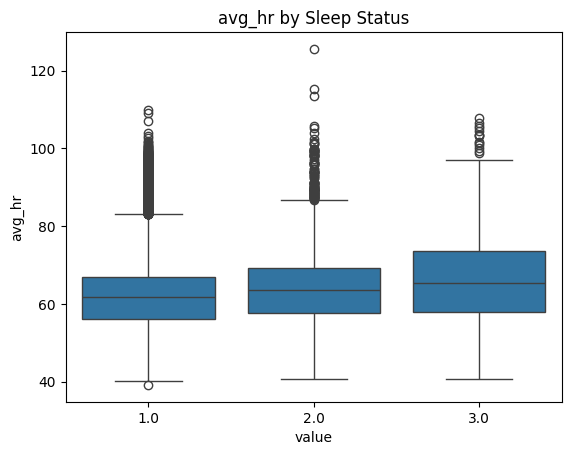

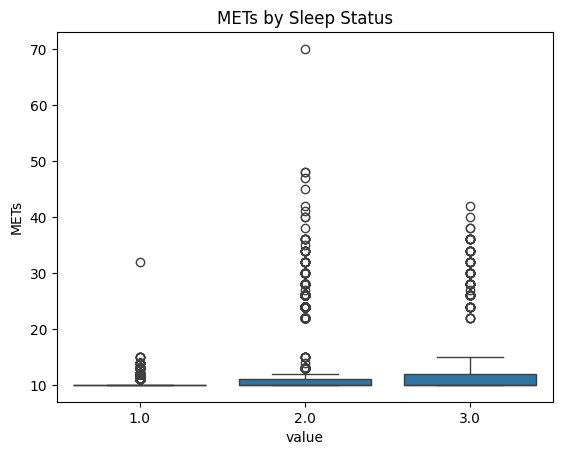

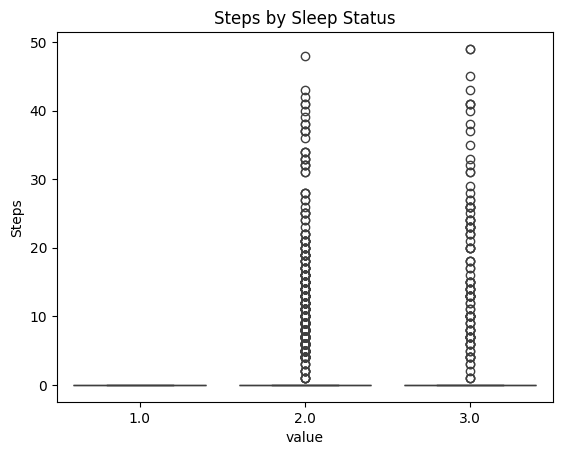

In [216]:
features = ['avg_hr', 'METs', 'Steps']

for f in features:
    sns.boxplot(
        x='value',
        y=f,
        data=sleep_status_merge_df
    )
    plt.title(f'{f} by Sleep Status')
    plt.show()

<Axes: xlabel='hour', ylabel='count'>

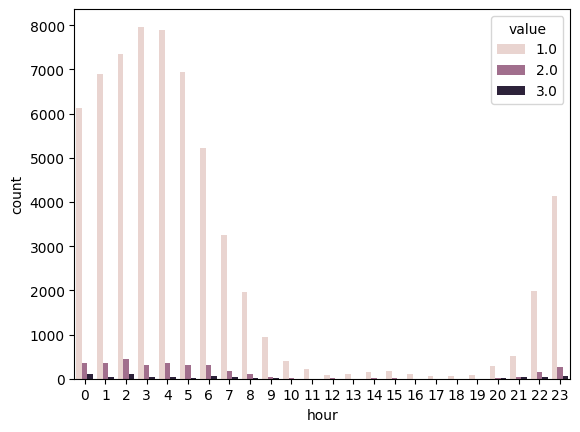

In [218]:
sleep_status_merge_df['hour'] = sleep_status_merge_df['ActivityMinute'].dt.hour

sns.countplot(
    x='hour',
    hue='value',
    data=sleep_status_merge_df
)

<Axes: xlabel='Id'>

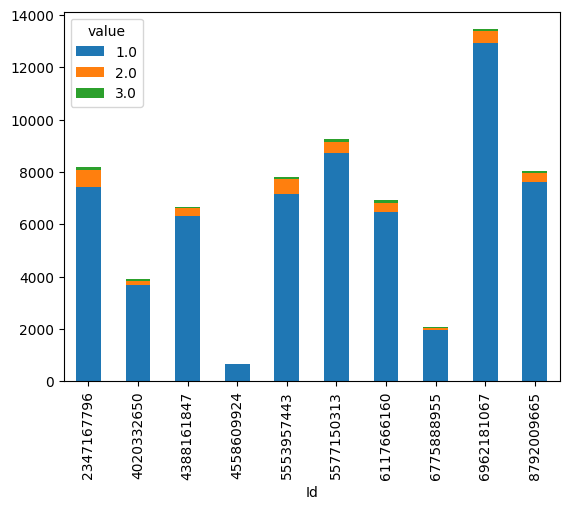

In [219]:
user_sleep_dist = (
    sleep_status_merge_df.groupby(['Id','value'])
           .size()
           .unstack(fill_value=0)
)

user_sleep_dist.plot(kind='bar', stacked=True)

#### Interpretation

In this dataset, sleep status is classified into three device-defined categories:
`1 = Asleep, 2 = Restless, and 3 = Awake`.

From the boxplots, the average heart rate during the `Asleep` state is consistently lower than in the other two states, which aligns with expected physiological patterns during sleep. In contrast, the `Awake` state exhibits significantly higher heart rates and greater variability, reflecting increased physical and mental activity. A similar trend is observed for METs, where activity intensity increases progressively from Asleep to `Awake`.

Notably, the `Restless` state shows a larger number of high-value outliers in both heart rate and `METs`. This suggests intermittent body movements, such as turning or repositioning during sleep, which are captured by wearable sensors as short bursts of activity. Correspondingly, step counts occasionally appear in both Restless and `Awake` states, likely caused by motion artifacts rather than sustained walking behavior.

Temporal distribution analysis indicates that most sleep records occur during nighttime hours, consistent with typical circadian sleep patterns. However, a non-negligible portion of sleep observations is also present during daytime, which may correspond to daytime naps or irregular sleep schedules.

Finally, user-level distributions reveal that most individuals exhibit a dominant `Asleep` state, with fewer observations in `Restless` and Awake states. This consistent pattern across users suggests stable sleep behavior and supports the generalizability of downstream sleep state modeling.





### 1.3.2 Features Correlation

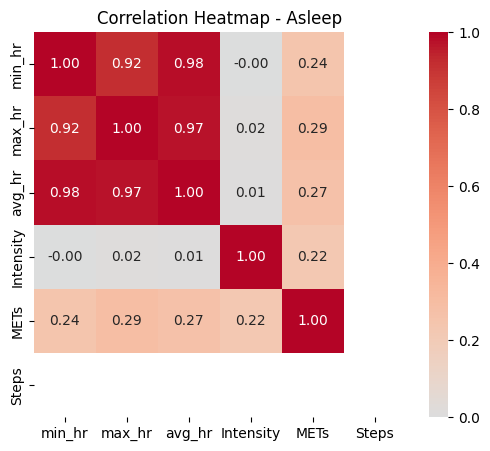

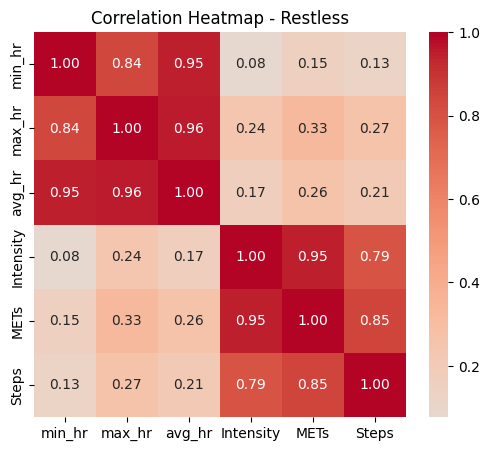

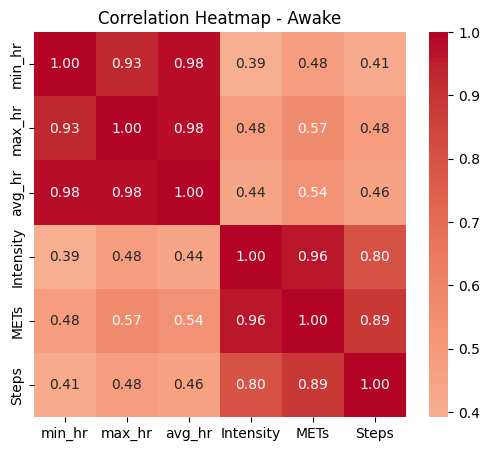

In [224]:
for status, label in {
    1: 'Asleep',
    2: 'Restless',
    3: 'Awake'
}.items():
    corr = (
        sleep_status_merge_df
        .query("value == @status")[['min_hr','max_hr','avg_hr','Intensity','METs','Steps']]
        .corr()
    )

    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title(f"Correlation Heatmap - {label}")
    plt.show()

## 1.4 Save cleaned datasets

In [235]:
calories_merged_df[['Id', 'ActivityMinute', 'Calories', 'Intensity', 'METs', 'Steps', 'WeightPounds', 'BMI']]. \
      to_csv(google_drive_path + '/calories_merged_df.csv')
sleep_status_merge_df[['Id', 'ActivityMinute', 'min_hr', 'max_hr', 'avg_hr', 'Intensity', 'METs', 'Steps', 'value', 'segment_uid']]. \
      to_csv(google_drive_path + '/sleep_status_merge_df.csv')

In [230]:
# load cleaned dataset

# calories_merged_df = pd.read_csv(google_drive_path + '/calories_merged_df.csv')
# sleep_status_merge_df = pd.read_csv(google_drive_path + '/sleep_status_merge_df.csv')
# sleep_status_merge_df

,Unnamed: 0,Id,ActivityMinute,min_hr,max_hr,avg_hr,Intensity,METs,Steps,value,time_diff,new_segment,segment_id,segment_uid,hour
0,0,2347167796,2016-03-29 00:00:00,68,69,69,0,10,0,1,NaN,True,1,2347167796_1,0
1,1,2347167796,2016-03-29 00:01:00,68,69,69,0,10,0,1,60,False,1,2347167796_1,0
2,2,2347167796,2016-03-29 00:02:00,68,70,69,0,10,0,1,60,False,1,2347167796_1,0
3,3,2347167796,2016-03-29 00:03:00,67,70,68,0,10,0,1,60,False,1,2347167796_1,0
4,4,2347167796,2016-03-29 00:04:00,69,70,69,0,10,0,1,60,False,1,2347167796_1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66931,66931,8792009665,2016-05-04 09:58:00,64,64,64,0,10,0,1,60,False,21,8792009665_21,9
66932,66932,8792009665,2016-05-04 09:59:00,64,64,64,0,10,0,1,60,False,21,8792009665_21,9
66933,66933,8792009665,2016-05-04 10:00:00,64,64,64,0,10,0,1,60,False,21,8792009665_21,10
66934,66934,8792009665,2016-05-04 10:02:00,64,80,72,0,10,0,1,120,False,21,8792009665_21,10
